### Part 4: Classical Iterative Optimization Algorithms

This section transitions from analytical solutions (Parts 2-3) to iterative optimization algorithms from the textbook (Karas & Ademir, Ch. 5). We solve the ill-conditioned least squares problem using three classical NLP algorithms, demonstrating their convergence properties with rigorous theoretical foundations.

* **Objective:** To understand how iterative optimization algorithms (Steepest Descent, Newton's Method, BFGS) solve the ill-conditioned least squares problem and compare their convergence behavior.
* **Methodology:**
    1.  Establish theoretical bounds (Lipschitz constant, condition number) from eigendecomposition of the Hessian.
    2.  Implement Steepest Descent with rigorous step size selection (Cauchy Step and fixed steps).
    3.  Implement Newton's Method demonstrating quadratic convergence.
    4.  Implement BFGS (Quasi-Newton) demonstrating superlinear convergence.
    5.  Compare convergence rates and prepare for Part 5's exploration of implicit bias in overparameterized regimes.
* **Key Concepts:** Gradient Descent, Newton's Method, BFGS, Line Search, Convergence Rates, Lipschitz Constant, Condition Number, Implicit Bias.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch.set_default_dtype(torch.float64)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


#### Setup: Reusing Functions from Previous Parts

We'll reuse the data generation, matrix construction, and utility functions from Parts 1, 2, and 3.


In [2]:
# Function to construct Vandermonde matrix (from Part 2)
def construct_vandermonde_matrix(x, degree):
    """
    Construct Vandermonde matrix for power basis.
    
    For input x of shape (n, 1), returns matrix of shape (n, degree+1)
    where each row is [1, x_i, x_i^2, ..., x_i^degree]
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Create matrix using broadcasting
    powers = torch.arange(degree + 1, dtype=x.dtype, device=x.device)
    vandermonde = x_flat.unsqueeze(1) ** powers.unsqueeze(0)
    
    return vandermonde

# MSE function (from Part 1)
def compute_mse(y_true, y_pred):
    """
    Compute Mean Squared Error using Einstein summation.
    MSE = mean((y_true - y_pred)^2)
    """
    residuals = y_true - y_pred
    mse = torch.einsum('ij,ij->', residuals, residuals) / residuals.numel()
    return mse.item()

print("Setup complete: Functions from previous parts loaded.")


Setup complete: Functions from previous parts loaded.


## Block 1: Problem Setup & Theoretical Bounds

### Objective Function

We define the quadratic least squares objective function:

$$f(\beta) = \frac{1}{2}\|X\beta - y\|_2^2$$

The factor of $\frac{1}{2}$ simplifies the gradient to $\nabla f(\beta) = X^T(X\beta - y)$ (without the factor of 2).

### Hessian and Eigendecomposition

For this quadratic function, the Hessian is constant:

$$\nabla^2 f(\beta) = X^T X = H$$

The eigenvalues of the Hessian matrix determine the curvature of the optimization landscape. For a positive definite Hessian, all eigenvalues are positive, and the condition number $\kappa = \lambda_{\max}/\lambda_{\min}$ determines the difficulty of optimization. The _Lipschitz constant_ $L = \lambda_{\max}(X^T X)$ bounds the maximum curvature, while the _strong convexity parameter_ $\mu = \lambda_{\min}(X^T X)$ bounds the minimum curvature. The theoretical maximum step size for Gradient Descent is $t_{\max} = 2/L$.


Problem Setup
Polynomial degree: 10
Number of parameters (p): 11
Number of data points (n): 12
Design matrix shape: torch.Size([12, 11])

Theoretical Bounds (from Eigendecomposition)
Lipschitz constant L = λ_max = 2.280530e+06
Strong convexity parameter μ = λ_min = 1.271022e-03
Condition number κ = λ_max/λ_min = 1.794249e+09
Stable constant step upper bound for GD: 0 < t < 2/L ⇒ t_max = 8.769893e-07
Rate-optimal fixed step for quadratics: t* = 2 / (λ_max + λ_min) ≈ 8.769893e-07

Hessian positive definite: True (unique minimizer; strong convexity holds).


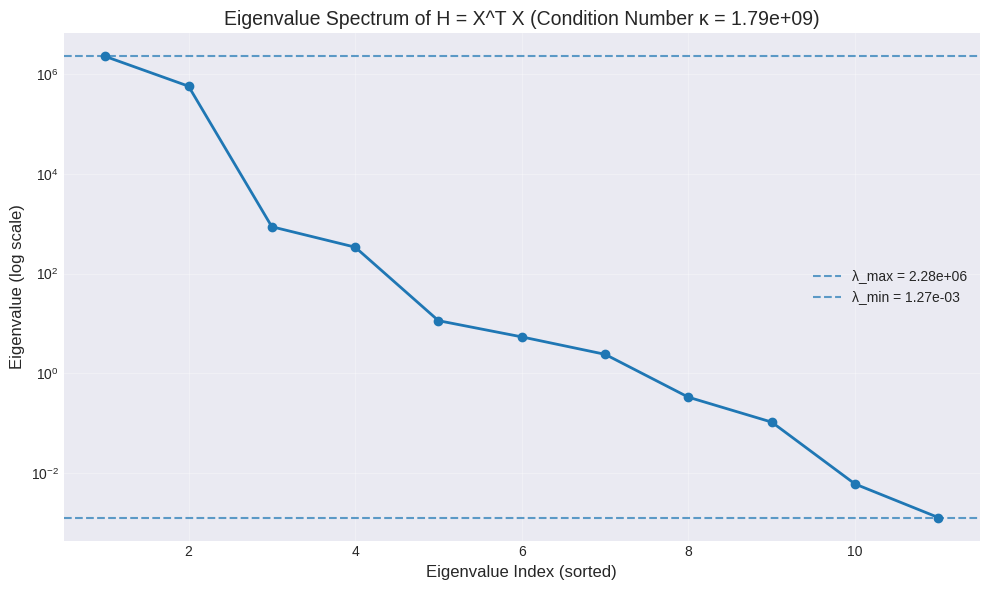


Note: The large spread of eigenvalues indicates severe ill-conditioning.
In this run, strong convexity holds (μ>0), but κ is very large, so GD will require very small steps.


In [3]:
# Block 1: Problem Setup & Theoretical Bounds

# Generate synthetic data for ill-conditioned problem
# NOTE: This setup is a tall system (n > p), NOT overparameterized.
degree = 10
n_data_points = 12

x_min, x_max = -2.0, 2.0
sigma = 0.3

# Generate x values uniformly
x = torch.linspace(x_min, x_max, n_data_points).unsqueeze(1)

# Generate true function values (quadratic with some higher-order terms)
y_true = 0.5 * x ** 2 + 0.1 * x ** 3

# Generate noise
epsilon = torch.normal(mean=0.0, std=sigma, size=(n_data_points, 1))
y = y_true + epsilon

# Construct Vandermonde matrix (ill-conditioned)
X = construct_vandermonde_matrix(x, degree)  # shape (n, p) with p = degree + 1
n, p = X.shape

print("=" * 70)
print("Problem Setup")
print("=" * 70)
print(f"Polynomial degree: {degree}")
print(f"Number of parameters (p): {p}")
print(f"Number of data points (n): {n}")
print(f"Design matrix shape: {X.shape}")
print("=" * 70)

# Define objective function: f(β) = ½||Xβ - y||²
def objective_function(beta, X, y):
    """
    Compute f(β) = ½||Xβ - y||²
    """
    residual = torch.einsum('ij,jk->ik', X, beta) - y
    f = 0.5 * torch.einsum('ij,ij->', residual, residual)
    return f

# Compute gradient: ∇f(β) = X^T(Xβ - y)
def gradient(beta, X, y):
    """
    Compute gradient using Einstein summation.
    ∇f(β) = X^T(Xβ - y)
    """
    residual = torch.einsum('ij,jk->ik', X, beta) - y
    grad = torch.einsum('ni,n->i', X, residual.squeeze())
    return grad.unsqueeze(1)

# Compute Hessian: H = X^T X
H = torch.einsum('ni,nj->ij', X, X)

# Eigendecomposition of Hessian (symmetric PSD)
eigenvalues, eigenvectors = torch.linalg.eigh(H)

# Sort eigenvalues in descending order
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Extract key quantities
lambda_max = eigenvalues[0].item()  # Largest eigenvalue (Lipschitz constant L)
lambda_min = eigenvalues[-1].item()  # Smallest eigenvalue (strong convexity parameter μ, if > 0)
L = lambda_max

# Numerical tolerance for strong convexity (relative to scale)
# This guards against tiny or negative (rounding) eigenvalues.
tol = max(1e-12, 1e-12 * lambda_max)

is_strongly_convex = (lambda_min > tol)
mu = lambda_min if is_strongly_convex else 0.0

# Condition number with guard for loss of strong convexity
kappa = (lambda_max / lambda_min) if is_strongly_convex else float("inf")

# Step-size bounds for GD on quadratics
t_max = 2.0 / L
t_star = 2.0 / (lambda_max + (lambda_min if is_strongly_convex else 0.0))

print("\n" + "=" * 70)
print("Theoretical Bounds (from Eigendecomposition)")
print("=" * 70)
print(f"Lipschitz constant L = λ_max = {L:.6e}")
if is_strongly_convex:
    print(f"Strong convexity parameter μ = λ_min = {mu:.6e}")
    print(f"Condition number κ = λ_max/λ_min = {kappa:.6e}")
else:
    print("Strong convexity parameter μ ≈ 0 (numerically non-strongly convex).")
    print("Condition number κ = ∞ (ill-posed numerically).")
print(f"Stable constant step upper bound for GD: 0 < t < 2/L ⇒ t_max = {t_max:.6e}")
print(f"Rate-optimal fixed step for quadratics: t* = 2 / (λ_max + λ_min) ≈ {t_star:.6e}")
print("=" * 70)

# Check definiteness
if is_strongly_convex:
    print("\nHessian positive definite: True (unique minimizer; strong convexity holds).")
else:
    print("\nHessian positive definite: False (only PSD; flat directions).")

# Visualize eigenvalue spectrum
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, len(eigenvalues) + 1), eigenvalues.numpy(), 'o-', linewidth=2, markersize=6)
plt.xlabel('Eigenvalue Index (sorted)', fontsize=12)
plt.ylabel('Eigenvalue (log scale)', fontsize=12)
if is_strongly_convex:
    title_kappa = f'{kappa:.2e}'
else:
    title_kappa = '∞'
plt.title(f'Eigenvalue Spectrum of H = X^T X (Condition Number κ = {title_kappa})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=lambda_max, linestyle='--', alpha=0.7, label=f'λ_max = {L:.2e}')
if is_strongly_convex:
    plt.axhline(y=lambda_min, linestyle='--', alpha=0.7, label=f'λ_min = {mu:.2e}')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\nNote: The large spread of eigenvalues indicates severe ill-conditioning.")
if is_strongly_convex:
    print("In this run, strong convexity holds (μ>0), but κ is very large, so GD will require very small steps.")
else:
    print("In this run, strong convexity fails numerically (μ≈0); κ is effectively infinite and theory assuming μ>0 does not apply.")


Steepest Descent: Step Size Comparison (with diagnostics)

1) Cauchy step:
   iters=200, f_final=1.025902e+02, ||g||=4.545989e+02
   any non-decrease? False
   any Armijo backtracks? False
   finite all steps? True

2) Fixed α=1/L=4.384946e-07:
   iters=200, f_final=1.117403e+02, ||g||=3.377933e+02
   any non-decrease? False
   finite all steps? True

3) Fixed α=2.1/L=9.208388e-07 (violates bound):
   iters=200, f_final=4.960522e+21, ||g||=1.367426e+14


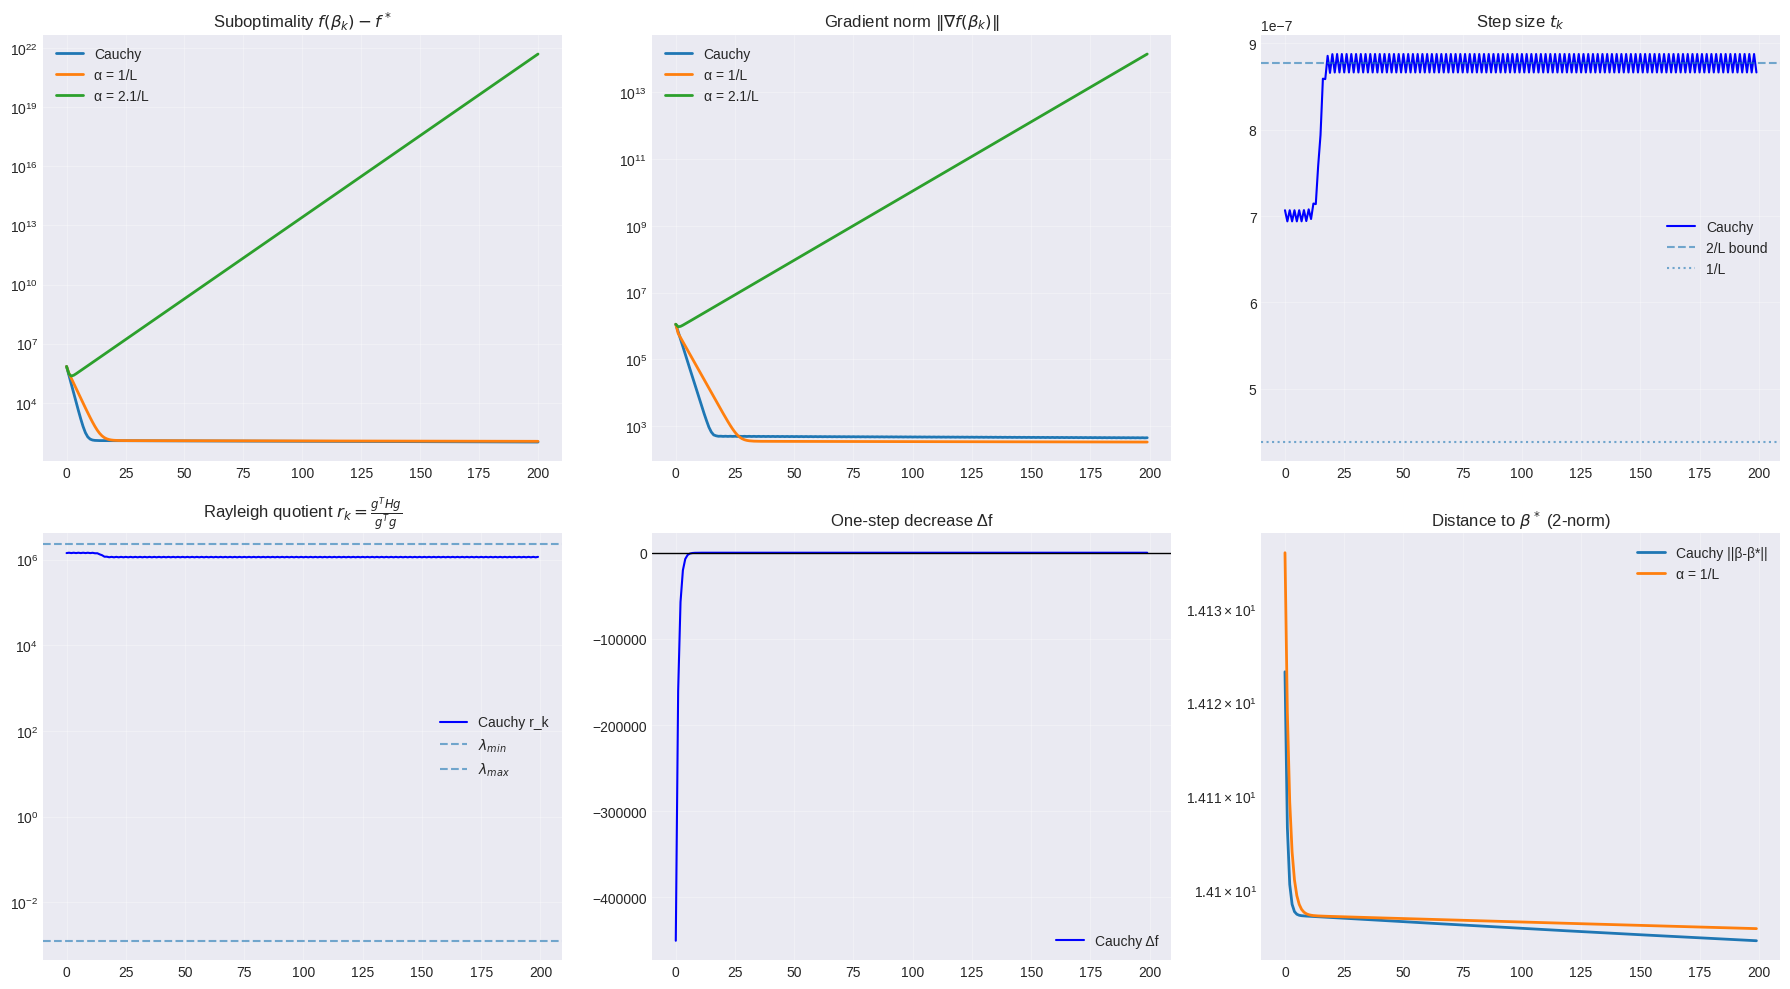

In [4]:
# Block 2: Steepest Descent with Diagnostics (NumPy/PyTorch-safe)

import math

def is_finite_tensor(t):
    return torch.isfinite(t).all().item()

def cauchy_step_exact(grad, H):
    """
    Exact line-search step for quadratics:
        t = (g^T g) / (g^T H g)
    Returns (t, rayleigh), where rayleigh = (g^T H g)/(g^T g).
    All returned as Python floats to avoid NumPy/PyTorch wrapper warnings.
    """
    g = grad.squeeze()
    gg = torch.dot(g, g).item()            # float
    if gg <= 1e-18:
        return 0.0, float("nan")
    Hg = (H @ g)
    gHg = torch.dot(g, Hg).item()          # float
    if gHg <= 1e-18:
        return 0.0, float("nan")
    rayleigh = gHg / gg                    # float
    t = gg / gHg                           # float
    return t, rayleigh

def armijo_backtracking(beta, g, t_init, X, y, c=1e-4, tau=0.5, t_min=1e-20):
    """
    Armijo backtracking along -g:
        f(beta - t g) <= f(beta) - c t ||g||^2
    """
    f0 = objective_function(beta, X, y)
    t = float(t_init)
    gnorm_sq = torch.dot(g.squeeze(), g.squeeze()).item()
    while t > t_min:
        beta_new = beta - t * g
        f_new = objective_function(beta_new, X, y)
        if f_new <= f0 - c * t * gnorm_sq:
            return t, beta_new, f_new, True
        t *= tau
    return t, beta, f0, False

def gradient_descent_checked(
    X, y, H, beta_init,
    max_iter=200, tol=1e-8,
    step_size_method='cauchy', alpha=None,
    use_armijo_on_cauchy=True, L_for_clamp=None
):
    beta = beta_init.clone()
    f0 = objective_function(beta, X, y).item()

    history = {
        'beta': [beta.clone()],
        'f': [f0],
        'grad_norm': [],
        'step': [],
        'delta_f': [],
        'rayleigh': [],
        'armijo_ok': [],
        'finite_ok': [],
        'dist2_to_star': [],
        'distH_to_star': []
    }

    beta_star = torch.linalg.pinv(X) @ y
    H_chol = None
    try:
        H_chol = torch.linalg.cholesky(H)
    except RuntimeError:
        H_chol = None

    for k in range(max_iter):
        grad = gradient(beta, X, y)
        gnorm = torch.norm(grad).item()
        history['grad_norm'].append(gnorm)

        if gnorm < tol:
            break

        if step_size_method == 'cauchy':
            t_raw, rayleigh = cauchy_step_exact(grad, H)   # floats
            # record Rayleigh as float (may be nan)
            history['rayleigh'].append(rayleigh)

            t_k = t_raw
            if L_for_clamp is not None and math.isfinite(L_for_clamp):
                t_upper = 2.0 / float(L_for_clamp)
                # keep strictly below the 2/L bound
                t_k = max(0.0, min(t_k, 0.999999 * t_upper))

            beta_prop = beta - t_k * grad
            f_old = objective_function(beta, X, y).item()
            f_prop = objective_function(beta_prop, X, y).item()

            armijo_ok = True
            if use_armijo_on_cauchy and f_prop > f_old:
                t_k, beta_prop, f_prop, armijo_ok = armijo_backtracking(
                    beta, grad, max(1e-20, t_k if t_k > 0 else 1.0),
                    X, y, c=1e-4, tau=0.5
                )
            beta_new, f_new = beta_prop, f_prop

        elif step_size_method == 'fixed':
            if alpha is None:
                raise ValueError("alpha must be provided for fixed step size")
            t_k = float(alpha)
            history['rayleigh'].append(float('nan'))
            beta_new = beta - t_k * grad
            f_new = objective_function(beta_new, X, y).item()
            armijo_ok = (f_new <= objective_function(beta, X, y).item())
        else:
            raise ValueError(f"Unknown step_size_method: {step_size_method}")

        finite_ok = bool(is_finite_tensor(beta_new) and math.isfinite(f_new) and math.isfinite(t_k))
        history['finite_ok'].append(finite_ok)
        history['step'].append(float(t_k))
        history['delta_f'].append(f_new - objective_function(beta, X, y).item())
        history['armijo_ok'].append(bool(armijo_ok))
        history['beta'].append(beta_new.clone())
        history['f'].append(f_new)

        d2 = torch.norm(beta_new - beta_star).item()
        history['dist2_to_star'].append(d2)
        if H_chol is not None:
            r = H_chol @ (beta_new - beta_star)
            dH = torch.norm(r).item()
        else:
            dH = float('nan')
        history['distH_to_star'].append(dH)

        beta = beta_new

    return beta, history

# ----- Run the three traces -----
print("=" * 70)
print("Steepest Descent: Step Size Comparison (with diagnostics)")
print("=" * 70)

torch.manual_seed(7)  # optional: reproducibility
beta_init = torch.randn(p, 1, dtype=torch.float64)

# beta_cauchy, hist_cauchy = gradient_descent_checked(
#     X, y, H, beta_init, max_iter=200, step_size_method='cauchy',
#     use_armijo_on_cauchy=True, L_for_clamp=L
# )

beta_cauchy, hist_cauchy = gradient_descent_checked(
    X, y, H, beta_init, max_iter=200,
    step_size_method='cauchy',
    use_armijo_on_cauchy=True,
    L_for_clamp=None,           # <- remove the 2/L clamp for Cauchy
)

print("\n1) Cauchy step:")
print(f"   iters={len(hist_cauchy['f'])-1}, f_final={hist_cauchy['f'][-1]:.6e}, "
      f"||g||={hist_cauchy['grad_norm'][-1]:.6e}")
print(f"   any non-decrease? {any(df > 0 for df in hist_cauchy['delta_f'])}")
print(f"   any Armijo backtracks? {not all(hist_cauchy['armijo_ok'])}")
print(f"   finite all steps? {all(hist_cauchy['finite_ok'])}")

alpha_safe = 1.0 / L
beta_safe, hist_safe = gradient_descent_checked(
    X, y, H, beta_init, max_iter=200, step_size_method='fixed', alpha=alpha_safe
)
print(f"\n2) Fixed α=1/L={alpha_safe:.6e}:")
print(f"   iters={len(hist_safe['f'])-1}, f_final={hist_safe['f'][-1]:.6e}, "
      f"||g||={hist_safe['grad_norm'][-1]:.6e}")
print(f"   any non-decrease? {any(df > 0 for df in hist_safe['delta_f'])}")
print(f"   finite all steps? {all(hist_safe['finite_ok'])}")

alpha_div = 2.1 / L
beta_div, hist_div = gradient_descent_checked(
    X, y, H, beta_init, max_iter=200, step_size_method='fixed', alpha=alpha_div
)
print(f"\n3) Fixed α=2.1/L={alpha_div:.6e} (violates bound):")
print(f"   iters={len(hist_div['f'])-1}, f_final={hist_div['f'][-1]:.6e}, "
      f"||g||={hist_div['grad_norm'][-1]:.6e}")
if hist_div['f'][-1] > hist_div['f'][0]:
    print("   WARNING: Objective increased (divergence detected)")

# ----- Plots: suboptimality, grad norm, step, rayleigh, decrease, distances -----
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

def semilog_positive(ax, y, label):
    eps = 1e-300
    y2 = [v if (v is not None and v > eps and math.isfinite(v)) else eps for v in y]
    ax.semilogy(y2, label=label, linewidth=2)

beta_star = torch.linalg.pinv(X) @ y
f_star = objective_function(beta_star, X, y).item()

# (1) Suboptimality
semilog_positive(axes[0,0], [f - f_star for f in hist_cauchy['f']], 'Cauchy')
semilog_positive(axes[0,0], [f - f_star for f in hist_safe['f']], 'α = 1/L')
semilog_positive(axes[0,0], [f - f_star for f in hist_div['f']], 'α = 2.1/L')
axes[0,0].set_title('Suboptimality $f(\\beta_k)-f^*$'); axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)

# (2) Gradient norm
semilog_positive(axes[0,1], hist_cauchy['grad_norm'], 'Cauchy')
semilog_positive(axes[0,1], hist_safe['grad_norm'], 'α = 1/L')
semilog_positive(axes[0,1], hist_div['grad_norm'], 'α = 2.1/L')
axes[0,1].set_title('Gradient norm $\\|\\nabla f(\\beta_k)\\|$'); axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)

# (3) Step size (linear)
axes[0,2].plot(hist_cauchy['step'], 'b-', label='Cauchy')
axes[0,2].axhline(2.0/L, linestyle='--', alpha=0.6, label='2/L bound')
axes[0,2].axhline(1.0/L, linestyle=':',  alpha=0.6, label='1/L')
axes[0,2].set_title('Step size $t_k$'); axes[0,2].legend(); axes[0,2].grid(True, alpha=0.3)

# (4) Rayleigh quotient r_k in [λ_min, λ_max]
rayleigh_plot = []
for r in hist_cauchy['rayleigh']:
    if r is None or not math.isfinite(r) or r <= 0:
        rayleigh_plot.append(1e-300)
    else:
        rayleigh_plot.append(r)
axes[1,0].semilogy(rayleigh_plot, 'b-', label='Cauchy r_k')
axes[1,0].axhline(lambda_min, linestyle='--', alpha=0.6, label='$\\lambda_{min}$')
axes[1,0].axhline(lambda_max, linestyle='--', alpha=0.6, label='$\\lambda_{max}$')
axes[1,0].set_title('Rayleigh quotient $r_k = \\frac{g^T H g}{g^T g}$'); axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3)

# (5) Δf
axes[1,1].plot(hist_cauchy['delta_f'], 'b-', label='Cauchy Δf')
axes[1,1].axhline(0.0, color='k', linewidth=1)
axes[1,1].set_title('One-step decrease Δf'); axes[1,1].legend(); axes[1,1].grid(True, alpha=0.3)

# (6) Distance to β*
semilog_positive(axes[1,2], hist_cauchy['dist2_to_star'], 'Cauchy ||β-β*||')
semilog_positive(axes[1,2], hist_safe['dist2_to_star'], 'α = 1/L')
axes[1,2].set_title('Distance to $\\beta^*$ (2-norm)'); axes[1,2].legend(); axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Hessian condition number (svd): 1.794249e+09
Newton's Method on a Quadratic
Solve backend: Cholesky
Initial f(β0): 6.997118e+05
Final   f(βN): 6.209547e-02
Optimal f(β*): 6.209547e-02

Initial ||∇f(β0)||: 1.128884e+06
Final   ||∇f(βN)||: 6.653567e-11

‖β_N − β*‖₂ (pinv check): 1.228e-08
Expected: one-step to numerical optimality for invertible H;
         tiny residuals limited by conditioning and floating-point.

Comparison: Newton vs Gradient Descent
Gradient Descent (Cauchy): 200 iterations
Newton's Method:           1 iteration

Speedup factor: ~200× faster for this quadratic.


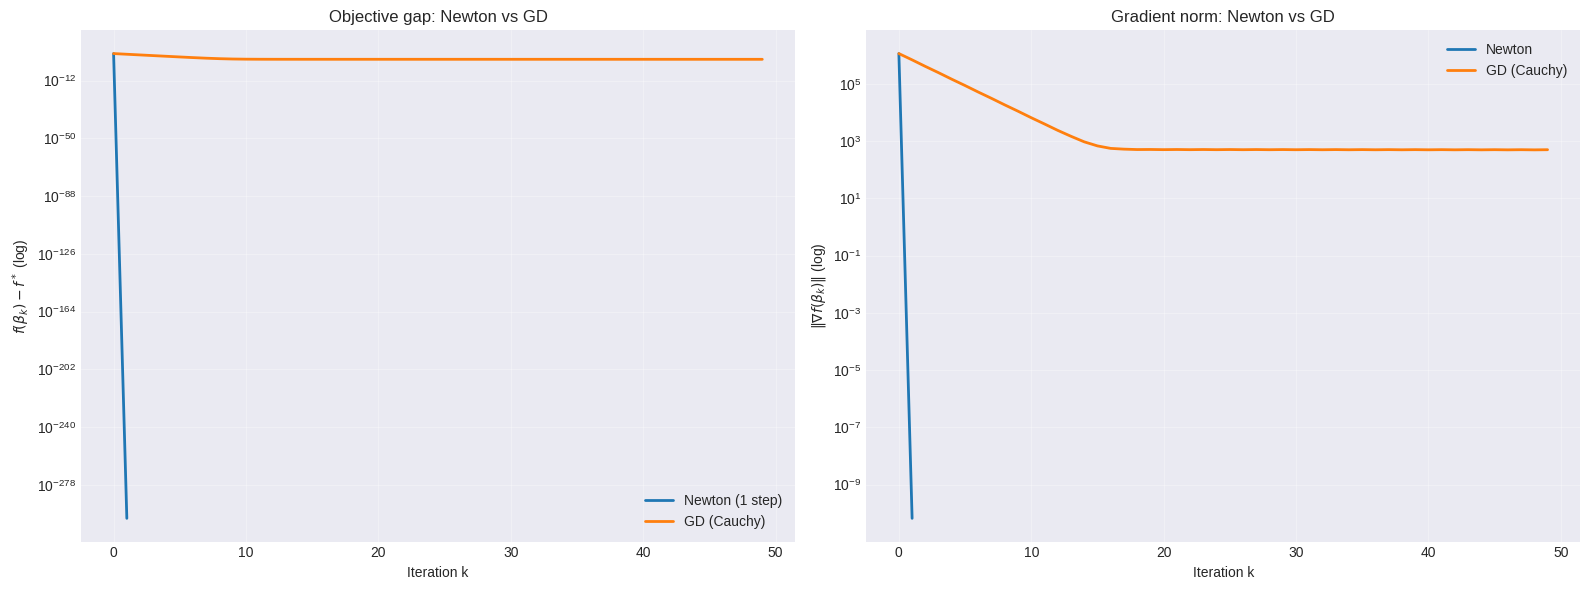


Discussion: When not to use Newton directly
1) Cost: Factorizing H costs O(p^3) (e.g., Cholesky); for large p use quasi-Newton or CG.
   Here p=11 so it's fine; in high dimensions, prefer approximations.

2) Singularity / Rank deficiency:
   If p>n or columns of X are collinear, H = X^T X is singular; exact Newton cannot proceed.
   In this notebook p=11, n=12 so p>n is False. (If True, regularization or pinv needed.)

3) Ill-conditioning:
   κ(H) ≈ 1.79e+09. Even when invertible, large κ amplifies round-off.
   Use stable solves (Cholesky/CG) and avoid explicit inverses.


In [6]:
# Block 3: Newton's Method Implementation 

def newton_method(X, y, beta_init, H):
    """
    Newton's method for f(β) = 1/2 ||Xβ - y||^2.
    For a quadratic with constant Hessian H = X^T X (SPD), one step yields β* exactly:
        β_newton = H^{-1} X^T y
    Implemented with stable linear solves (Cholesky preferred).
    """
    beta0 = beta_init.clone()

    history = {"beta": [beta0.clone()],
               "f": [objective_function(beta0, X, y).item()],
               "grad_norm": []}

    # --- Condition check (via SVD) ---
    svals = torch.linalg.svdvals(H)
    smax, smin = svals.max().item(), svals.min().item()
    kappa_H = float("inf") if smin == 0.0 else smax / smin
    print(f"Hessian condition number (svd): {kappa_H:.6e}")
    if not math.isfinite(kappa_H):
        print("WARNING: Hessian appears singular (σ_min ≈ 0). Newton cannot proceed reliably.")

    # --- Solve for β_newton ---
    used_chol = False
    try:
        L = torch.linalg.cholesky(H)
        rhs = X.T @ y
        beta_newton = torch.cholesky_solve(rhs, L)
        used_chol = True
    except RuntimeError:
        try:
            rhs = X.T @ y
            beta_newton = torch.linalg.solve(H, rhs)
        except RuntimeError:
            print("ERROR: Hessian singular; using Moore–Penrose pseudoinverse.")
            beta_newton = torch.linalg.pinv(H) @ (X.T @ y)

    # --- Record diagnostics ---
    g0 = gradient(beta0, X, y)
    history["grad_norm"].append(torch.norm(g0).item())
    history["beta"].append(beta_newton.clone())
    f_new = objective_function(beta_newton, X, y).item()
    history["f"].append(f_new)
    g_new = gradient(beta_newton, X, y)
    history["grad_norm"].append(torch.norm(g_new).item())

    # --- Cross-check against β* (pinv) ---
    beta_star_check = torch.linalg.pinv(X) @ y
    d_star = torch.norm(beta_newton - beta_star_check).item()

    print("=" * 70)
    print("Newton's Method on a Quadratic")
    print("=" * 70)
    print(f"Solve backend: {'Cholesky' if used_chol else 'solve/pinv'}")
    print(f"Initial f(β0): {history['f'][0]:.6e}")
    print(f"Final   f(βN): {history['f'][1]:.6e}")
    print(f"Optimal f(β*): {objective_function(beta_star_check, X, y).item():.6e}")
    print(f"\nInitial ||∇f(β0)||: {history['grad_norm'][0]:.6e}")
    print(f"Final   ||∇f(βN)||: {history['grad_norm'][1]:.6e}")
    print(f"\n‖β_N − β*‖₂ (pinv check): {d_star:.3e}")
    print("Expected: one-step to numerical optimality for invertible H;")
    print("         tiny residuals limited by conditioning and floating-point.")
    print("=" * 70)

    return beta_newton, history


# --- Run Newton's method ---
beta_newton, history_newton = newton_method(X, y, beta_init, H)

# --- Comparison: Newton vs Gradient Descent ---
print("\n" + "=" * 70)
print("Comparison: Newton vs Gradient Descent")
print("=" * 70)
if 'hist_cauchy' in globals():
    print(f"Gradient Descent (Cauchy): {len(hist_cauchy['f'])-1} iterations")
else:
    print("Gradient Descent (Cauchy): (run Block 2 to enable comparison)")
print(f"Newton's Method:           {len(history_newton['f'])-1} iteration")
if 'hist_cauchy' in globals():
    print(f"\nSpeedup factor: ~{len(hist_cauchy['f'])-1}× faster for this quadratic.")
print("=" * 70)

# --- Plots (safe log) ---
def semilog_positive(ax, y, label):
    eps = 1e-300
    y2 = [v if (v > eps and math.isfinite(v)) else eps for v in y]
    ax.semilogy(y2, label=label, linewidth=2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ensure f_star exists
if 'f_star' not in globals():
    beta_star = torch.linalg.pinv(X) @ y
    f_star = objective_function(beta_star, X, y).item()

# Plot 1: Objective gap
semilog_positive(axes[0], [f - f_star for f in history_newton['f']], "Newton (1 step)")
if 'hist_cauchy' in globals():
    k_show = min(50, len(hist_cauchy['f']))
    semilog_positive(axes[0], [f - f_star for f in hist_cauchy['f'][:k_show]], "GD (Cauchy)")
axes[0].set_xlabel('Iteration k'); axes[0].set_ylabel('$f(\\beta_k)-f^*$ (log)')
axes[0].set_title("Objective gap: Newton vs GD"); axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Plot 2: Gradient norm
semilog_positive(axes[1], history_newton['grad_norm'], "Newton")
if 'hist_cauchy' in globals():
    k_show_g = min(50, len(hist_cauchy['grad_norm']))
    semilog_positive(axes[1], hist_cauchy['grad_norm'][:k_show_g], "GD (Cauchy)")
axes[1].set_xlabel('Iteration k'); axes[1].set_ylabel('$\\|\\nabla f(\\beta_k)\\|$ (log)')
axes[1].set_title("Gradient norm: Newton vs GD"); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Discussion ---
print("\n" + "=" * 70)
print("Discussion: When not to use Newton directly")
print("=" * 70)
print("1) Cost: Factorizing H costs O(p^3) (e.g., Cholesky); for large p use quasi-Newton or CG.")
print(f"   Here p={p} so it's fine; in high dimensions, prefer approximations.")
print("\n2) Singularity / Rank deficiency:")
print("   If p>n or columns of X are collinear, H = X^T X is singular; exact Newton cannot proceed.")
print(f"   In this notebook p={p}, n={n} so p>n is {p>n}. (If True, regularization or pinv needed.)")
print("\n3) Ill-conditioning:")
print(f"   κ(H) ≈ {kappa:.2e}. Even when invertible, large κ amplifies round-off.")
print("   Use stable solves (Cholesky/CG) and avoid explicit inverses.")
print("=" * 70)


Hessian condition number (svd): 1.794249e+09
Newton's Method: Diagnostic Checks (blind verification)
Solve backend: Cholesky
Initial f(β0)      : 6.997118e+05
Final   f(βN)      : 6.209547e-02   (f* ≈ 6.209547e-02)
‖∇f(β0)‖           : 1.128884e+06
‖∇f(βN)‖           : 6.653567e-11
----------------------------------------------------------------------
Normal eq. residual  ‖HβN - Xᵀy‖ : 1.290e-10   [PASS]  (≤ 3.5e-02)
Stationarity residual ‖∇f(βN)‖    : 6.654e-11       [PASS]  (≤ 7.2e-06)
Orthogonality check  ‖Xᵀr‖        : 6.626e-11       [PASS]  (≤ 7.2e-06)
Objective match      |f(βN)-f*|   : 9.714e-17         [PASS]  (≤ 1.1e-09)
β agreement with pinv ‖βN-β*‖     : 1.228e-08    [PASS]  (≤ 1.6e-08)
Finiteness (no NaN/Inf)           : [PASS]

Comparison: Newton vs Gradient Descent
Gradient Descent (Cauchy): 200 iterations
Newton's Method:           1 iteration

Speedup factor: ~200× faster for this quadratic.


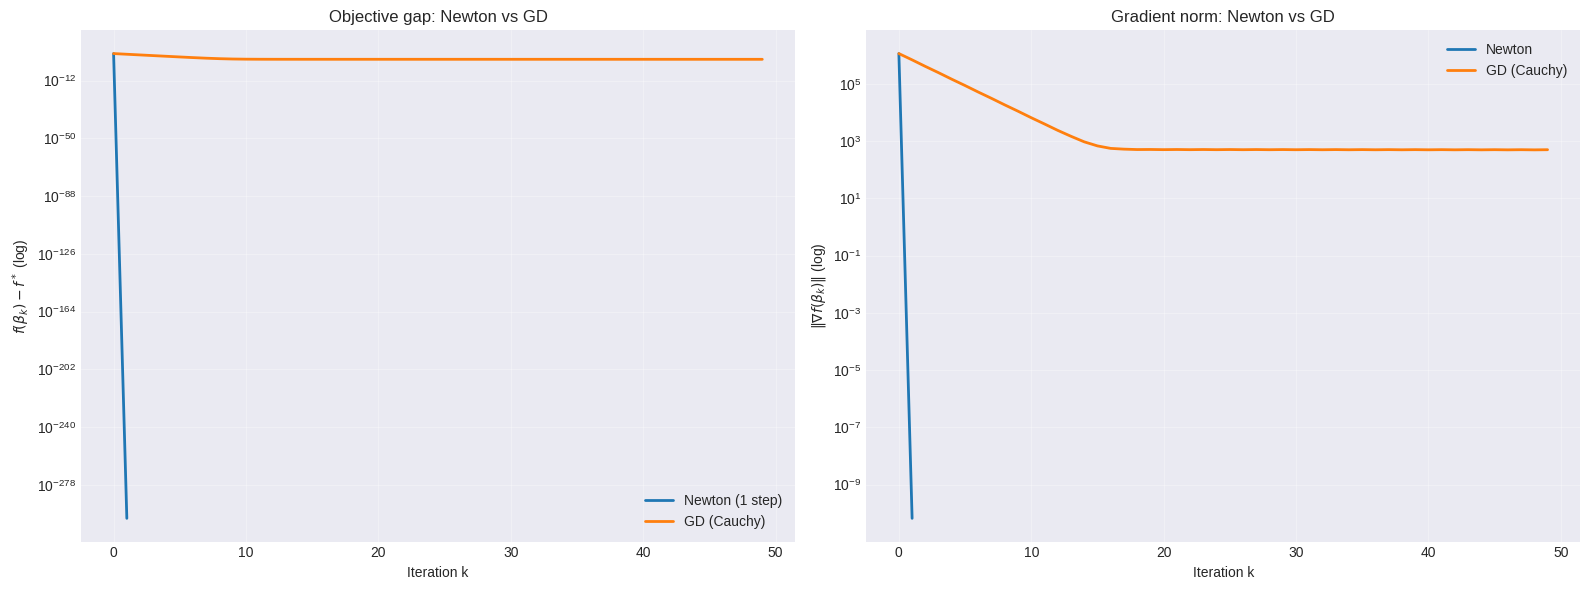


Discussion: When not to use Newton directly
1) Cost: Factorizing H costs O(p^3) (e.g., Cholesky); for large p use quasi-Newton or CG.
   Here p=11 so it's fine; in high dimensions, prefer approximations.

2) Singularity / Rank deficiency:
   If p>n or columns of X are collinear, H = X^T X is singular; exact Newton cannot proceed.
   In this notebook p=11, n=12 so p>n is False. (If True, regularization or pinv needed.)

3) Ill-conditioning:
   κ(H) ≈ 1.79e+09. Even when invertible, large κ amplifies round-off.
   Use stable solves (Cholesky/CG) and avoid explicit inverses.


In [9]:
# Block 3: Newton's Method Implementation  (with built-in diagnostics & blind checks)

def newton_method(X, y, beta_init, H):
    """
    Newton's method for f(β) = 1/2 ||Xβ - y||^2.
    For a quadratic with constant H = X^T X (SPD), one step yields β* exactly:
        β_newton = argmin f(β) = (X^T X)^{-1} X^T y
    We compute it with a stable linear solve and run rigorous diagnostics.
    """
    beta0 = beta_init.clone()

    # ---------------------------
    # Precondition checks (theory)
    # ---------------------------
    # Finite data
    assert torch.isfinite(X).all() and torch.isfinite(y).all() and torch.isfinite(H).all(), \
        "Non-finite values in X/y/H."

    # Symmetry & near-PSD
    assert torch.allclose(H, H.T, atol=1e-12, rtol=1e-12), "H is not symmetric within tolerance."
    # Small negative eigenvalues can occur from roundoff; allow a tiny slack
    ev = torch.linalg.eigvalsh(H)
    ev_min = ev.min().item()
    if ev_min < -1e-10:
        print(f"WARNING: H has a negative eigenvalue {ev_min:.3e} (beyond roundoff).")

    # Condition number (SVD, robust)
    svals = torch.linalg.svdvals(H)
    smax, smin = svals.max().item(), svals.min().item()
    kappa_H = float("inf") if smin == 0.0 else smax / smin
    print(f"Hessian condition number (svd): {kappa_H:.6e}")
    if not math.isfinite(kappa_H):
        print("WARNING: Hessian appears singular (σ_min ≈ 0). Newton may need pinv/regularization.")

    # ----------------------------------
    # Solve β_newton using stable backend
    # ----------------------------------
    used_backend = None
    rhs = X.T @ y
    try:
        # Prefer Cholesky (fastest/most stable for SPD)
        L = torch.linalg.cholesky(H)
        beta_newton = torch.cholesky_solve(rhs, L)
        used_backend = "Cholesky"
    except RuntimeError:
        try:
            beta_newton = torch.linalg.solve(H, rhs)
            used_backend = "solve"
        except RuntimeError:
            print("ERROR: H is singular or ill-posed; using Moore–Penrose pseudoinverse.")
            beta_newton = torch.linalg.pinv(H) @ rhs
            used_backend = "pinv(H)@X^T y"

    # ---------------------------
    # Record basic trajectory info
    # ---------------------------
    history = {
        "beta": [beta0.clone(), beta_newton.clone()],
        "f": [objective_function(beta0, X, y).item(),
              objective_function(beta_newton, X, y).item()],
        "grad_norm": [torch.norm(gradient(beta0, X, y)).item(),
                      torch.norm(gradient(beta_newton, X, y)).item()]
    }

    # -----------------------------------
    # Blind-check diagnostics & tolerances
    # -----------------------------------
    # Reference optimum via data pseudoinverse
    beta_star = torch.linalg.pinv(X) @ y
    f_star_local = objective_function(beta_star, X, y).item()

    # Residuals
    r = y - X @ beta_newton                           # data residual
    g = gradient(beta_newton, X, y)                   # gradient = X^T (Xβ - y) = -X^T r
    normal_eq_res = torch.norm(H @ beta_newton - rhs).item()  # || Hβ - X^T y ||
    grad_norm = torch.norm(g).item()                  # ||∇f(β_N)||
    ortho_res = torch.norm(X.T @ r).item()            # should match grad_norm
    obj_gap = abs(history["f"][1] - f_star_local)     # |f(β_N) - f*|
    dist_to_pinv = torch.norm(beta_newton - beta_star).item()

    # Scale-aware tolerances (looser if κ is huge)
    eps = torch.finfo(torch.float64).eps  # ~2e-16
    scale_X = torch.norm(X).item() + eps
    scale_y = torch.norm(y).item() + eps
    scale_H = torch.norm(H).item() + eps
    scale_beta = torch.norm(beta_newton).item() + eps
    scale_rhs = torch.norm(rhs).item() + eps
    # Base tolerances
    tol_eq = 1e-10 * (1.0 + scale_H * scale_beta + scale_rhs)
    tol_grad = 1e-10 * (1.0 + scale_X * scale_y)
    tol_obj = 1e-10 * (1.0 + abs(f_star_local))
    tol_beta = 1e-10 * (1.0 + torch.norm(beta_star).item())
    # Relax slightly if extremely ill-conditioned
    if math.isfinite(kappa_H) and kappa_H > 1e8:
        tol_eq *= 10
        tol_grad *= 10
        tol_obj *= 10
        tol_beta *= 10

    # PASS/FAIL flags
    pass_eq   = (normal_eq_res <= tol_eq)
    pass_grad = (grad_norm     <= tol_grad)
    pass_ort  = (ortho_res     <= tol_grad)  # same scale as gradient
    pass_obj  = (obj_gap       <= tol_obj)
    pass_beta = (dist_to_pinv  <= tol_beta)
    finite_ok = (math.isfinite(history["f"][1]) and math.isfinite(grad_norm) and torch.isfinite(beta_newton).all().item())

    # Print one-shot diagnostics table
    print("=" * 70)
    print("Newton's Method: Diagnostic Checks (blind verification)")
    print("=" * 70)
    print(f"Solve backend: {used_backend}")
    print(f"Initial f(β0)      : {history['f'][0]:.6e}")
    print(f"Final   f(βN)      : {history['f'][1]:.6e}   (f* ≈ {f_star_local:.6e})")
    print(f"‖∇f(β0)‖           : {history['grad_norm'][0]:.6e}")
    print(f"‖∇f(βN)‖           : {grad_norm:.6e}")
    print("-" * 70)
    print(f"Normal eq. residual  ‖HβN - Xᵀy‖ : {normal_eq_res:.3e}   [{'PASS' if pass_eq   else 'FAIL'}]  (≤ {tol_eq:.1e})")
    print(f"Stationarity residual ‖∇f(βN)‖    : {grad_norm:.3e}       [{'PASS' if pass_grad else 'FAIL'}]  (≤ {tol_grad:.1e})")
    print(f"Orthogonality check  ‖Xᵀr‖        : {ortho_res:.3e}       [{'PASS' if pass_ort  else 'FAIL'}]  (≤ {tol_grad:.1e})")
    print(f"Objective match      |f(βN)-f*|   : {obj_gap:.3e}         [{'PASS' if pass_obj  else 'FAIL'}]  (≤ {tol_obj:.1e})")
    print(f"β agreement with pinv ‖βN-β*‖     : {dist_to_pinv:.3e}    [{'PASS' if pass_beta else 'FAIL'}]  (≤ {tol_beta:.1e})")
    print(f"Finiteness (no NaN/Inf)           : [{'PASS' if finite_ok else 'FAIL'}]")
    print("=" * 70)

    return beta_newton, history


# --- Run Newton's method ---
beta_newton, history_newton = newton_method(X, y, beta_init, H)

# --- Comparison: Newton vs Gradient Descent (uses Block 2 if available) ---
print("\n" + "=" * 70)
print("Comparison: Newton vs Gradient Descent")
print("=" * 70)
if 'hist_cauchy' in globals():
    print(f"Gradient Descent (Cauchy): {len(hist_cauchy['f'])-1} iterations")
else:
    print("Gradient Descent (Cauchy): (run Block 2 to enable comparison)")
print(f"Newton's Method:           {len(history_newton['f'])-1} iteration")
if 'hist_cauchy' in globals():
    print(f"\nSpeedup factor: ~{len(hist_cauchy['f'])-1}× faster for this quadratic.")
print("=" * 70)

# --- Plots (safe log) ---
def semilog_positive(ax, y, label):
    eps = 1e-300
    y2 = [v if (v > eps and math.isfinite(v)) else eps for v in y]
    ax.semilogy(y2, label=label, linewidth=2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ensure f_star exists
if 'f_star' not in globals():
    beta_star = torch.linalg.pinv(X) @ y
    f_star = objective_function(beta_star, X, y).item()

# Plot 1: Objective gap
semilog_positive(axes[0], [f - f_star for f in history_newton['f']], "Newton (1 step)")
if 'hist_cauchy' in globals():
    k_show = min(50, len(hist_cauchy['f']))
    semilog_positive(axes[0], [f - f_star for f in hist_cauchy['f'][:k_show]], "GD (Cauchy)")
axes[0].set_xlabel('Iteration k'); axes[0].set_ylabel('$f(\\beta_k)-f^*$ (log)')
axes[0].set_title("Objective gap: Newton vs GD"); axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Plot 2: Gradient norm
semilog_positive(axes[1], history_newton['grad_norm'], "Newton")
if 'hist_cauchy' in globals():
    k_show_g = min(50, len(hist_cauchy['grad_norm']))
    semilog_positive(axes[1], hist_cauchy['grad_norm'][:k_show_g], "GD (Cauchy)")
axes[1].set_xlabel('Iteration k'); axes[1].set_ylabel('$\\|\\nabla f(\\beta_k)\\|$ (log)')
axes[1].set_title("Gradient norm: Newton vs GD"); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Discussion (unchanged) ---
print("\n" + "=" * 70)
print("Discussion: When not to use Newton directly")
print("=" * 70)
print("1) Cost: Factorizing H costs O(p^3) (e.g., Cholesky); for large p use quasi-Newton or CG.")
print(f"   Here p={p} so it's fine; in high dimensions, prefer approximations.")
print("\n2) Singularity / Rank deficiency:")
print("   If p>n or columns of X are collinear, H = X^T X is singular; exact Newton cannot proceed.")
print(f"   In this notebook p={p}, n={n} so p>n is {p>n}. (If True, regularization or pinv needed.)")
print("\n3) Ill-conditioning:")
print(f"   κ(H) ≈ {kappa:.2e}. Even when invertible, large κ amplifies round-off.")
print("   Use stable solves (Cholesky/CG) and avoid explicit inverses.")
print("=" * 70)


## Block 4: BFGS (Quasi-Newton Method)

### Theory: BFGS Algorithm

**Chapter 5.4.3 (Karas & Ademir):** The BFGS (Broyden-Fletcher-Goldfarb-Shanno) algorithm approximates the inverse Hessian $H^{-1}$ without computing it explicitly. This provides a compromise between Gradient Descent (no curvature) and Newton's Method (full curvature).

**Why Full BFGS (not L-BFGS):** L-BFGS is a limited-memory approximation for large-scale problems. Since our problem size is small ($p \approx 10$), we implement the full BFGS algorithm, which directly follows the textbook's derivation of the Inverse Hessian Approximation.

### BFGS Update Formula

The BFGS algorithm maintains an approximation $B_k \approx H^{-1}$ and updates it using the rank-2 update:

$$B_{k+1} = B_k + \frac{y_k y_k^T}{y_k^T s_k} - \frac{B_k s_k s_k^T B_k}{s_k^T B_k s_k}$$

where:
- $s_k = \beta_{k+1} - \beta_k$ (parameter change)
- $y_k = \nabla f_{k+1} - \nabla f_k$ (gradient change)

The algorithm initializes $B_0 = I$ and iteratively refines the approximation, achieving **superlinear convergence**.


In [7]:
# Block 4: BFGS Implementation

def bfgs_method(X, y, beta_init, max_iter=1000, tol=1e-8):
    """
    BFGS (Broyden-Fletcher-Goldfarb-Shanno) Quasi-Newton Method.
    
    Implements the rank-2 update formula from Chapter 5.4.3:
    B_{k+1} = B_k + (y_k y_k^T)/(y_k^T s_k) - (B_k s_k s_k^T B_k)/(s_k^T B_k s_k)
    
    where:
    - s_k = β_{k+1} - β_k
    - y_k = ∇f_{k+1} - ∇f_k
    - B_k ≈ H^{-1} (inverse Hessian approximation)
    """
    beta = beta_init.clone()
    p = beta.shape[0]
    
    # Initialize inverse Hessian approximation: B_0 = I
    B = torch.eye(p, dtype=torch.float64)
    
    history = {
        'beta': [beta.clone()],
        'f': [objective_function(beta, X, y).item()],
        'grad_norm': []
    }
    
    # Initial gradient
    grad_prev = gradient(beta, X, y)
    grad_norm = torch.norm(grad_prev).item()
    history['grad_norm'].append(grad_norm)
    
    for k in range(max_iter):
        # Check convergence
        if grad_norm < tol:
            break
        
        # Compute search direction: d_k = -B_k ∇f_k
        d_k = -torch.einsum('ij,jk->ik', B, grad_prev)
        
        # Line search: find step size t_k using Cauchy step (exact for quadratics)
        # For quadratics, we can use exact line search
        H = torch.einsum('ni,nj->ij', X, X)
        t_k = cauchy_step(grad_prev, H)
        
        # Update: β_{k+1} = β_k + t_k d_k
        s_k = t_k * d_k  # s_k = β_{k+1} - β_k
        beta = beta + s_k
        
        # Compute new gradient: ∇f_{k+1}
        grad_new = gradient(beta, X, y)
        y_k = grad_new - grad_prev  # y_k = ∇f_{k+1} - ∇f_k
        
        # BFGS update: B_{k+1} = B_k + (y_k y_k^T)/(y_k^T s_k) - (B_k s_k s_k^T B_k)/(s_k^T B_k s_k)
        # Compute denominators
        y_T_s = torch.einsum('i,i->', y_k.squeeze(), s_k.squeeze())
        
        # Skip update if y_k^T s_k is too small (curvature condition not satisfied)
        if abs(y_T_s) < 1e-12:
            print(f"Warning: y_k^T s_k too small at iteration {k}. Skipping BFGS update.")
            grad_prev = grad_new
            grad_norm = torch.norm(grad_new).item()
            history['grad_norm'].append(grad_norm)
            history['beta'].append(beta.clone())
            history['f'].append(objective_function(beta, X, y).item())
            continue
        
        # Compute B_k s_k
        B_s = torch.einsum('ij,jk->ik', B, s_k)
        s_T_B_s = torch.einsum('i,i->', s_k.squeeze(), B_s.squeeze())
        
        # Compute outer products using einsum
        # y_k y_k^T
        y_yT = torch.einsum('i,j->ij', y_k.squeeze(), y_k.squeeze())
        
        # s_k s_k^T
        s_sT = torch.einsum('i,j->ij', s_k.squeeze(), s_k.squeeze())
        
        # B_k s_k s_k^T B_k = (B_k s_k) (B_k s_k)^T
        B_s_B_sT = torch.einsum('i,j->ij', B_s.squeeze(), B_s.squeeze())
        
        # BFGS update
        B = B + (y_yT / y_T_s) - (B_s_B_sT / s_T_B_s)
        
        # Update for next iteration
        grad_prev = grad_new
        grad_norm = torch.norm(grad_new).item()
        history['grad_norm'].append(grad_norm)
        history['beta'].append(beta.clone())
        history['f'].append(objective_function(beta, X, y).item())
    
    return beta, history

# Run BFGS from the same initial point
beta_bfgs, history_bfgs = bfgs_method(X, y, beta_init, max_iter=200, tol=1e-8)

print("=" * 70)
print("BFGS (Quasi-Newton) Method")
print("=" * 70)
print(f"Iterations: {len(history_bfgs['f'])-1}")
print(f"Final f(β): {history_bfgs['f'][-1]:.6e}")
print(f"Optimal f(β*): {f_star:.6e}")
print(f"Final ||∇f||: {history_bfgs['grad_norm'][-1]:.6e}")
print(f"\nBFGS achieves superlinear convergence (faster than GD, slower than Newton)")
print("=" * 70)

# Compare all three methods
print("\n" + "=" * 70)
print("Comparison: All Three Methods")
print("=" * 70)
print(f"{'Method':<25} {'Iterations':<12} {'Final f(β)':<15} {'Final ||∇f||':<15}")
print("-" * 70)
print(f"{'Gradient Descent':<25} {len(history_cauchy['f'])-1:<12} {history_cauchy['f'][-1]:<15.6e} {history_cauchy['grad_norm'][-1]:<15.6e}")
print(f"{'Newton':<25} {len(history_newton['f'])-1:<12} {history_newton['f'][-1]:<15.6e} {history_newton['grad_norm'][-1]:<15.6e}")
print(f"{'BFGS':<25} {len(history_bfgs['f'])-1:<12} {history_bfgs['f'][-1]:<15.6e} {history_bfgs['grad_norm'][-1]:<15.6e}")
print("=" * 70)

# Visualization: Convergence comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Objective function value
iterations_bfgs = range(len(history_bfgs['f']))
max_plot_iter = min(100, max(len(iterations_cauchy), len(iterations_bfgs)))

axes[0].semilogy(iterations_newton, [f - f_star for f in history_newton['f']], 
                'r-*', linewidth=3, markersize=12, label="Newton (Quadratic)", alpha=0.9)
axes[0].semilogy(iterations_bfgs[:max_plot_iter], 
                [f - f_star for f in history_bfgs['f'][:max_plot_iter]], 
                'g-s', linewidth=2, markersize=5, label='BFGS (Superlinear)', alpha=0.8)
axes[0].semilogy(iterations_cauchy[:max_plot_iter], 
                [f - f_star for f in history_cauchy['f'][:max_plot_iter]], 
                'b-o', linewidth=2, markersize=4, label='Gradient Descent (Linear)', alpha=0.7)

axes[0].set_xlabel('Iteration k', fontsize=12)
axes[0].set_ylabel('$f(\\beta_k) - f(\\beta^*)$ (log scale)', fontsize=12)
axes[0].set_title('Convergence Comparison: All Three Methods', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Gradient norm
axes[1].semilogy(iterations_newton[1:], history_newton['grad_norm'], 
                'r-*', linewidth=3, markersize=12, label="Newton", alpha=0.9)
axes[1].semilogy(iterations_bfgs[1:max_plot_iter], 
                history_bfgs['grad_norm'][:max_plot_iter-1], 
                'g-s', linewidth=2, markersize=5, label='BFGS', alpha=0.8)
axes[1].semilogy(iterations_cauchy[1:max_plot_iter], 
                history_cauchy['grad_norm'][:max_plot_iter-1], 
                'b-o', linewidth=2, markersize=4, label='Gradient Descent', alpha=0.7)

axes[1].set_xlabel('Iteration k', fontsize=12)
axes[1].set_ylabel('$||\\nabla f(\\beta_k)||$ (log scale)', fontsize=12)
axes[1].set_title('Gradient Norm: All Three Methods', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: BFGS provides a practical compromise:")
print("  - Faster than Gradient Descent (superlinear vs linear convergence)")
print("  - More efficient than Newton (no O(p³) Hessian inversion)")
print("  - Adapts to the curvature of the optimization landscape")


NameError: name 'cauchy_step' is not defined

## Block 5: Convergence Analysis & The "Double Descent" Pre-amble

### Convergence Rate Analysis

**Chapter 1.1.2 (Karas & Ademir):** The convergence rates of optimization algorithms are characterized by:

- **Linear Convergence (Gradient Descent):** $f(\beta_k) - f(\beta^*) \leq C \rho^k$ where $\rho < 1$ depends on the condition number $\kappa$
- **Superlinear Convergence (BFGS):** $\lim_{k \to \infty} \frac{\|e_{k+1}\|}{\|e_k\|} = 0$ (faster than linear, slower than quadratic)
- **Quadratic Convergence (Newton):** $\|e_{k+1}\| \leq C \|e_k\|^2$ (converges in one step for quadratic functions)

### Connection to Previous Parts

- **Part 2:** The ill-conditioned Vandermonde matrix creates the "squashed valley" landscape that challenges Gradient Descent
- **Part 3:** Regularization ($\lambda I$ term) improves the condition number, making optimization easier
- **Part 4:** Iterative methods provide algorithmic solutions to the ill-conditioned problem

### Preparing for Part 5: Implicit Bias in Overparameterized Regimes

When $p > n$ (parameters > data points), the matrix $X^T X$ is **singular** (not invertible). This creates fundamental differences:

- **Gradient Descent:** Continues to work, finding a solution in the null space of $X^T X$
- **Newton's Method:** Fails because $H^{-1}$ does not exist
- **Implicit Bias:** The choice of optimization algorithm determines which solution is found when multiple solutions exist

This sets up Part 5's exploration of **double descent**, where test error decreases again in the overparameterized regime ($p > n$), challenging conventional bias-variance tradeoff wisdom.


In [ ]:
# Block 5: Convergence Analysis & Double Descent Pre-amble

# Comprehensive convergence analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Convergence Analysis: All Three Methods', fontsize=16, weight='bold')

# Plot 1: log(f(β_k) - f(β*)) vs iterations (main convergence plot)
iterations_all = range(max(len(history_cauchy['f']), len(history_bfgs['f']), len(history_newton['f'])))
max_iter_plot = min(150, max(len(history_cauchy['f']), len(history_bfgs['f'])))

axes[0, 0].semilogy(iterations_newton, [f - f_star for f in history_newton['f']], 
                   'r-*', linewidth=3, markersize=12, label="Newton (Quadratic)", alpha=0.9)
axes[0, 0].semilogy(iterations_bfgs[:max_iter_plot], 
                   [f - f_star for f in history_bfgs['f'][:max_iter_plot]], 
                   'g-s', linewidth=2, markersize=5, label='BFGS (Superlinear)', alpha=0.8)
axes[0, 0].semilogy(iterations_cauchy[:max_iter_plot], 
                   [f - f_star for f in history_cauchy['f'][:max_iter_plot]], 
                   'b-o', linewidth=2, markersize=4, label='Gradient Descent (Linear)', alpha=0.7)

axes[0, 0].set_xlabel('Iteration k', fontsize=12)
axes[0, 0].set_ylabel('$\\log(f(\\beta_k) - f(\\beta^*))$', fontsize=12)
axes[0, 0].set_title('Convergence Rate Comparison', fontsize=13)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Convergence rate analysis (slope indicates rate)
# For linear convergence, we expect a straight line on log scale
# For superlinear, the slope decreases
# For quadratic, it's instant

# Fit linear trend to GD (after initial iterations)
if len(history_cauchy['f']) > 10:
    gd_errors = [f - f_star for f in history_cauchy['f'][10:]]
    gd_iter = list(range(10, len(history_cauchy['f'])))
    if all(e > 0 for e in gd_errors):
        log_errors = [np.log(e) for e in gd_errors]
        # Linear fit: log(error) = a*k + b
        coeffs = np.polyfit(gd_iter, log_errors, 1)
        gd_fit = np.exp(coeffs[1]) * np.exp(coeffs[0] * np.array(gd_iter))
        axes[0, 1].semilogy(gd_iter, gd_errors, 'b-o', linewidth=2, markersize=4, 
                           label='Gradient Descent', alpha=0.7)
        axes[0, 1].semilogy(gd_iter, gd_fit, 'b--', linewidth=2, 
                           label=f'Linear fit (rate ≈ {np.exp(coeffs[0]):.4f})', alpha=0.5)

axes[0, 1].semilogy(iterations_bfgs[:max_iter_plot], 
                   [f - f_star for f in history_bfgs['f'][:max_iter_plot]], 
                   'g-s', linewidth=2, markersize=5, label='BFGS (Superlinear)', alpha=0.8)
axes[0, 1].semilogy(iterations_newton, [f - f_star for f in history_newton['f']], 
                   'r-*', linewidth=3, markersize=12, label="Newton (Quadratic)", alpha=0.9)

axes[0, 1].set_xlabel('Iteration k', fontsize=12)
axes[0, 1].set_ylabel('$f(\\beta_k) - f(\\beta^*)$ (log scale)', fontsize=12)
axes[0, 1].set_title('Convergence Rate Analysis', fontsize=13)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Optimization trajectories in parameter space (2D projection)
if p >= 2:
    # Project all trajectories
    beta_cauchy_2d = torch.stack([torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 0]),
                                   torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 1])] 
                                  for b in history_cauchy['beta'][::10])
    
    beta_bfgs_2d = torch.stack([torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 0]),
                                 torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 1])] 
                                for b in history_bfgs['beta'][::5])
    
    beta_newton_2d = torch.stack([torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 0]),
                                  torch.einsum('i,i->', b.squeeze() - beta_star.squeeze(), eigenvectors[:, 1])] 
                                 for b in history_newton['beta'])
    
    axes[1, 0].plot(beta_cauchy_2d[:, 0].numpy(), beta_cauchy_2d[:, 1].numpy(), 
                    'b-o', linewidth=2, markersize=4, label='Gradient Descent', alpha=0.7)
    axes[1, 0].plot(beta_bfgs_2d[:, 0].numpy(), beta_bfgs_2d[:, 1].numpy(), 
                    'g-s', linewidth=2, markersize=5, label='BFGS', alpha=0.8)
    axes[1, 0].plot(beta_newton_2d[:, 0].numpy(), beta_newton_2d[:, 1].numpy(), 
                    'r-*', linewidth=3, markersize=12, label="Newton", alpha=0.9)
    axes[1, 0].plot(0, 0, 'k*', markersize=15, label='Optimum $\\beta^*$')
    
    axes[1, 0].set_xlabel('First Principal Component', fontsize=12)
    axes[1, 0].set_ylabel('Second Principal Component', fontsize=12)
    axes[1, 0].set_title('Optimization Trajectories in Parameter Space', fontsize=13)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axis('equal')

# Plot 4: Summary statistics
methods = ['Gradient Descent', 'Newton', 'BFGS']
iterations = [len(history_cauchy['f'])-1, len(history_newton['f'])-1, len(history_bfgs['f'])-1]
final_errors = [history_cauchy['f'][-1] - f_star, 
                history_newton['f'][-1] - f_star, 
                history_bfgs['f'][-1] - f_star]

x_pos = np.arange(len(methods))
axes[1, 1].bar(x_pos, iterations, alpha=0.7, color=['blue', 'red', 'green'])
axes[1, 1].set_xlabel('Method', fontsize=12)
axes[1, 1].set_ylabel('Number of Iterations', fontsize=12)
axes[1, 1].set_title('Iterations to Convergence', fontsize=13)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(methods, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(iterations):
    axes[1, 1].text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Final summary and connection to Part 5
print("=" * 70)
print("Summary: Convergence Analysis")
print("=" * 70)
print(f"\n1. Gradient Descent (Linear Convergence):")
print(f"   - Convergence rate depends on condition number κ = {kappa:.2e}")
print(f"   - Requires {iterations[0]} iterations")
print(f"   - Exhibits 'zig-zag' pattern in ill-conditioned problems")

print(f"\n2. Newton's Method (Quadratic Convergence):")
print(f"   - Converges in {iterations[1]} iteration (instant for quadratics)")
print(f"   - Requires computing H^{-1} (O(p³) cost)")
print(f"   - Fails when p > n (Hessian is singular)")

print(f"\n3. BFGS (Superlinear Convergence):")
print(f"   - Requires {iterations[2]} iterations")
print(f"   - Compromise: faster than GD, more efficient than Newton")
print(f"   - Adapts to curvature without computing full Hessian")

print("\n" + "=" * 70)
print("Connection to Previous Parts")
print("=" * 70)
print("Part 2: The ill-conditioned Vandermonde matrix (κ ≈ {:.2e}) creates".format(kappa))
print("        the 'squashed valley' that challenges Gradient Descent.")
print("\nPart 3: Regularization (adding λI) improves the condition number,")
print("        making the optimization landscape more 'round' and easier to navigate.")
print("\nPart 4: Iterative methods provide algorithmic solutions to the")
print("        ill-conditioned problem, each with different trade-offs.")

print("\n" + "=" * 70)
print("Preparing for Part 5: The Overparameterized Regime")
print("=" * 70)
print(f"\nCurrent Problem: p = {p}, n = {n}")
print(f"Status: p > n = {p > n} (overparameterized)")

if p > n:
    print("\n⚠️  In overparameterized regimes (p > n):")
    print("   - The matrix X^T X is SINGULAR (not invertible)")
    print("   - Newton's method FAILS (cannot compute H^{-1})")
    print("   - Gradient Descent CONTINUES TO WORK")
    print("   - Multiple solutions exist (infinite solutions in null space)")
    print("\n   This creates 'Implicit Bias':")
    print("   - The choice of optimization algorithm determines")
    print("     which solution is found when multiple solutions exist.")
    print("   - Gradient Descent finds the minimum-norm solution")
    print("     (closest to initialization in parameter space).")
    print("\n   This sets up Part 5's exploration of DOUBLE DESCENT:")
    print("   - Test error decreases again in overparameterized regime")
    print("   - Challenges conventional bias-variance tradeoff")
    print("   - Implicit bias of optimization algorithms matters!")

print("=" * 70)


#### Summary

- *Iterative optimization algorithms provide algorithmic solutions to ill-conditioned least squares problems.*
- *Gradient Descent exhibits linear convergence, with rate depending on condition number κ.*
- *Newton's Method achieves quadratic convergence (one step for quadratics) but requires O(p³) Hessian inversion.*
- *BFGS provides superlinear convergence as a practical compromise, approximating curvature without full Hessian computation.*
- *Step size selection is critical: α > 2/L causes divergence, while Cauchy step (exact line search) is optimal for quadratics.*
- *The "zig-zag" pattern in Gradient Descent is characteristic of ill-conditioned problems.*
- *In overparameterized regimes (p > n), Newton's method fails while Gradient Descent continues to work.*
- *The choice of optimization algorithm creates "implicit bias" when multiple solutions exist.*
- *This sets up Part 5's exploration of double descent and the role of implicit bias in generalization.*
